In [78]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 16, 8
import matplotlib.pyplot as plt
import math
import numpy as np
import warnings
warnings.simplefilter('ignore')
import gym
import time
from IPython.display import clear_output
import itertools
import random
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from agents.utils.memory.ReplayMemory import ReplayMemory
from agents.utils.memory.Transition import Transition
import pandas as pd
import seaborn as sns
colors = ["#9d6d00", "#903ee0", "#11dc79", "#f568ff", "#419500", "#013fb0", 
          "#f2b64c", "#007ae4", "#ff905a", "#33d3e3", "#9e003a", "#019085", 
          "#950065", "#afc98f", "#ff9bfa", "#83221d", "#01668a", "#ff7c7c", 
          "#643561", "#75608a"]

# Laboratorio 2

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019

## CartPole con DQN, DDQN, Dueling DQN

In [2]:
class DQNSolver:
    def __init__(self, env, model, target, double=False, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=1, hidden_size=6,
                 render=False, debug=False):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.model = model.to(self.device)
        self.target = target.to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()
        
        self.double = double

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        
        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        current_tensors = [s for s in batch.next_state if s is not None]
        if current_tensors:
            non_final_next_states = torch.stack(current_tensors)
        else:
            return
        
        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            if not self.double:
                next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            else:
                non_final_best_actions_index=torch.argmax(self.model(non_final_next_states),1).unsqueeze(1)            
                next_state_values[non_final_mask] = self.target(non_final_next_states).\
                    gather(1, non_final_best_actions_index).squeeze(1).detach()         
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)


In [3]:
class DQN(nn.Module):

    def __init__(self, input_size, output_size, hidden_layers=2, hidden_size=24, init=True):
        super(DQN, self).__init__()
        self.input = nn.Linear(input_size, hidden_size)
        
        self.hidden = []
        for i in range(hidden_layers):
            layer = nn.Linear(hidden_size, hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
            
        self.output = nn.Linear(hidden_size, output_size)

        if init:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for layer in self.hidden:
            x = F.relu(layer(x))
        x = self.output(x)
        return x

In [4]:
class DuelingDQN(DQN):

    def __init__(self, input_size, output_size, hidden_layers=1, hidden_size=6, v_adv_layers=0, v_adv_size=6):
        super(DuelingDQN, self).__init__(input_size, hidden_size, hidden_layers, hidden_size, False)
        self.output_size = output_size
        
        self.adv_input = nn.Linear(hidden_size, v_adv_size)
        self.v_input = nn.Linear(hidden_size, v_adv_size)
        
        self.adv_layers = []
        for i in range(v_adv_layers):
            layer = nn.Linear(v_adv_size, v_adv_size)
            self.add_module('adv'+str(i), layer)
            self.adv_layers.append(layer)
            
        self.v_layers = []
        for i in range(v_adv_layers):
            layer = nn.Linear(v_adv_size, v_adv_size)
            self.add_module('v'+str(i), layer)
            self.v_layers.append(layer) 
            
        self.adv_output = nn.Linear(v_adv_size, output_size)
        self.v_output = nn.Linear(v_adv_size, 1)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    def forward(self, x):
        x = F.relu(super(DuelingDQN, self).forward(x))
        
        adv = F.relu(self.adv_input(x))
        v = F.relu(self.v_input(x))
        
        for layer in self.adv_layers:
            adv = F.relu(layer(adv))
        for layer in self.v_layers:
            v = F.relu(layer(v))
            
        adv = self.adv_output(adv)
        
        if len(adv.size()) > 1:
            # Model used with state single instance
            v = self.v_output(v).expand(adv.size(0), self.output_size)
            mean = adv.mean(1).unsqueeze(1).expand(adv.size(0), self.output_size)
        else:
            # Model used with sta
            v = self.v_output(v).expand(self.output_size)
            mean = adv.mean().unsqueeze(0).expand(self.output_size)

        x = v + adv - mean

        return x

In [5]:
EPISODES = 2000
DEBUG = True
BATCH_SIZE = 256

env = gym.make('CartPole-v0')
observation_space_size = env.observation_space.shape[0]
action_space_size = env.action_space.n

In [6]:
model = DQN(observation_space_size, action_space_size)
target = DQN(observation_space_size, action_space_size)

agent = DQNSolver(env, model, target, double=False, n_episodes=EPISODES, debug=DEBUG, batch_size=BATCH_SIZE)
scoresDQN, meanDQN = agent.run()

[Episode 0] - Mean reward 26.0.
[Episode 100] - Mean reward 69.24752475247524.
[Episode 200] - Mean reward 61.308457711442784.
[Episode 300] - Mean reward 55.78737541528239.
[Episode 400] - Mean reward 51.53615960099751.
[Episode 500] - Mean reward 51.80439121756487.
[Episode 600] - Mean reward 53.33277870216306.
[Episode 700] - Mean reward 54.22681883024251.
[Episode 800] - Mean reward 56.837702871410734.
[Episode 900] - Mean reward 57.44062153163152.
[Episode 1000] - Mean reward 60.03396603396603.
[Episode 1100] - Mean reward 61.86466848319709.
[Episode 1200] - Mean reward 63.616153205661945.
[Episode 1300] - Mean reward 67.87855495772483.
[Episode 1400] - Mean reward 72.4154175588865.
[Episode 1500] - Mean reward 74.97268487674883.
[Episode 1600] - Mean reward 76.86383510306058.
[Episode 1700] - Mean reward 78.4344503233392.
[Episode 1800] - Mean reward 81.40088839533593.
[Episode 1900] - Mean reward 83.36244082062072.
[Episode 1999] - Mean reward 85.258.


In [7]:
model = DQN(observation_space_size, action_space_size)
target = DQN(observation_space_size, action_space_size)

agent = DQNSolver(env, model, target, double=True, n_episodes=EPISODES, debug=DEBUG, batch_size=BATCH_SIZE)
scoresDDQN, meanDDQN = agent.run()

[Episode 0] - Mean reward 14.0.
[Episode 100] - Mean reward 45.46534653465346.
[Episode 200] - Mean reward 51.47761194029851.
[Episode 300] - Mean reward 60.87707641196013.
[Episode 400] - Mean reward 58.80548628428928.
[Episode 500] - Mean reward 56.399201596806385.
[Episode 600] - Mean reward 59.31946755407654.
[Episode 700] - Mean reward 61.63052781740371.
[Episode 800] - Mean reward 60.08988764044944.
[Episode 900] - Mean reward 61.67036625971143.
[Episode 1000] - Mean reward 63.31668331668332.
[Episode 1100] - Mean reward 63.33151680290645.
[Episode 1200] - Mean reward 65.46794338051623.
[Episode 1300] - Mean reward 66.67870868562645.
[Episode 1400] - Mean reward 68.2962169878658.
[Episode 1500] - Mean reward 69.709526982012.
[Episode 1600] - Mean reward 70.90131168019988.
[Episode 1700] - Mean reward 74.435038212816.
[Episode 1800] - Mean reward 77.45696835091616.
[Episode 1900] - Mean reward 80.40820620725934.
[Episode 1999] - Mean reward 81.7715.


In [34]:
model = DuelingDQN(observation_space_size, action_space_size)
target = DuelingDQN(observation_space_size, action_space_size)

agent = DQNSolver(env, model, target, double=False, n_episodes=EPISODES, debug=DEBUG, batch_size=BATCH_SIZE)
scoresDuelingDQN, meanDuelingDQN = agent.run()

[Episode 0] - Mean reward 13.0.
[Episode 100] - Mean reward 53.663366336633665.
[Episode 200] - Mean reward 47.930348258706466.
[Episode 300] - Mean reward 43.033222591362126.
[Episode 400] - Mean reward 42.46633416458853.
[Episode 500] - Mean reward 44.73652694610779.
[Episode 600] - Mean reward 48.51414309484193.
[Episode 700] - Mean reward 53.30527817403709.
[Episode 800] - Mean reward 61.764044943820224.
[Episode 900] - Mean reward 68.43951165371809.
[Episode 1000] - Mean reward 75.28371628371629.
[Episode 1100] - Mean reward 80.46594005449592.
[Episode 1200] - Mean reward 85.55120732722732.
[Episode 1300] - Mean reward 89.06610299769409.
[Episode 1400] - Mean reward 93.45467523197716.
[Episode 1500] - Mean reward 95.40906062624917.
[Episode 1600] - Mean reward 96.59962523422861.
[Episode 1700] - Mean reward 98.53439153439153.
[Episode 1800] - Mean reward 101.12270960577457.
[Episode 1900] - Mean reward 103.82272488164124.
[Episode 1999] - Mean reward 105.9185.


In [38]:
model = DuelingDQN(observation_space_size, action_space_size)
target = DuelingDQN(observation_space_size, action_space_size)

agent = DQNSolver(env, model, target, double=True, n_episodes=EPISODES, debug=DEBUG)
scoresDuelingDDQN, meanDuelingDDQN = agent.run()

[Episode 0] - Mean reward 9.0.
[Episode 100] - Mean reward 53.93069306930693.
[Episode 200] - Mean reward 50.47761194029851.
[Episode 300] - Mean reward 44.946843853820596.
[Episode 400] - Mean reward 42.35660847880299.
[Episode 500] - Mean reward 40.42914171656687.
[Episode 600] - Mean reward 40.10482529118136.
[Episode 700] - Mean reward 40.965763195435095.
[Episode 800] - Mean reward 43.48314606741573.
[Episode 900] - Mean reward 45.679245283018865.
[Episode 1000] - Mean reward 47.47852147852148.
[Episode 1100] - Mean reward 49.45958219800182.
[Episode 1200] - Mean reward 52.08742714404663.
[Episode 1300] - Mean reward 55.14681014604151.
[Episode 1400] - Mean reward 58.307637401855814.
[Episode 1500] - Mean reward 60.04930046635576.
[Episode 1600] - Mean reward 63.45034353529044.
[Episode 1700] - Mean reward 67.82304526748972.
[Episode 1800] - Mean reward 71.64075513603554.
[Episode 1900] - Mean reward 73.77695949500263.
[Episode 1999] - Mean reward 76.6295.


In [39]:
scores = pd.DataFrame({"DQN": scoresDQN, "DDQN": scoresDDQN, "DuelingDQN":scoresDuelingDQN, "DuelingDDQN": scoresDuelingDDQN } )
mean = pd.DataFrame({"DQN": meanDQN, "DDQN": meanDDQN, "DuelingDQN":meanDuelingDQN, "DuelingDDQN": meanDuelingDDQN } )

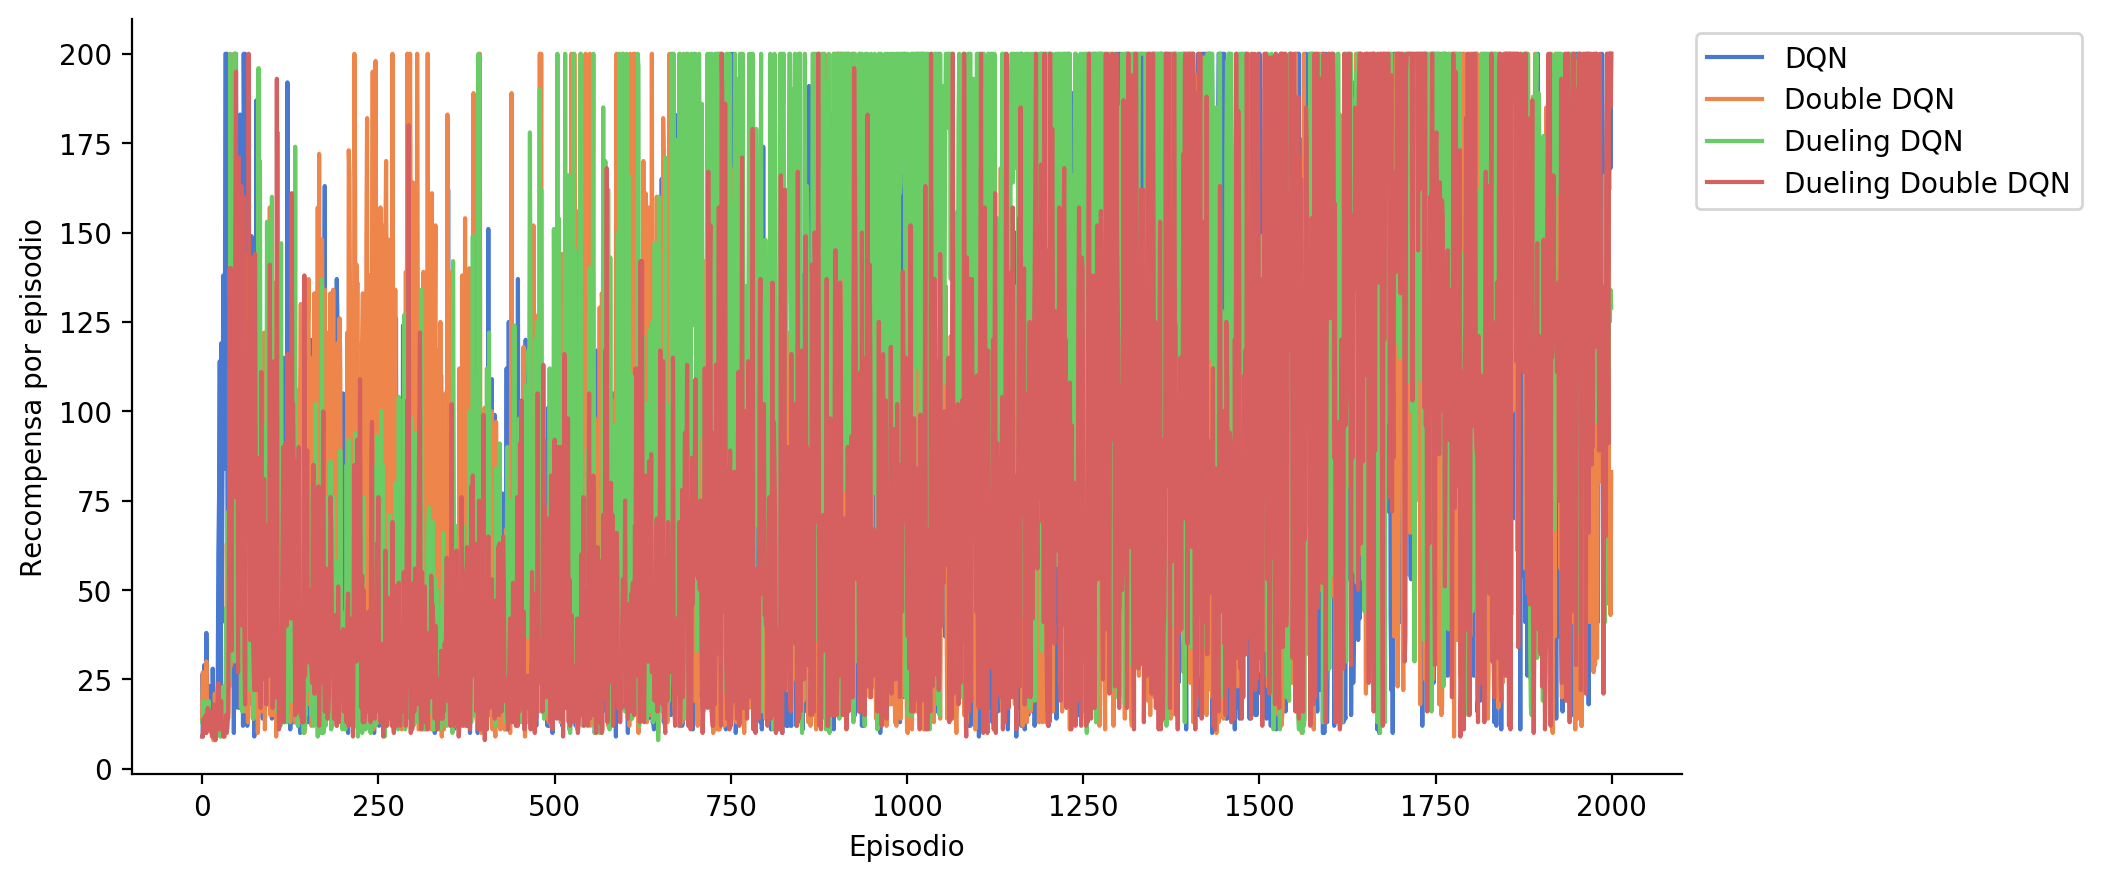

In [40]:
plt.figure(figsize=(10,5),dpi=200)
s = sns.lineplot(data=scores, dashes=False, palette="muted")
sns.despine()
s.set_xlabel("Episodio")
s.set_ylabel("Recompensa por episodio")
plt.legend(["DQN", "Double DQN", "Dueling DQN", "Dueling Double DQN"], bbox_to_anchor=(1,1))

In [ ]:
plt.figure(figsize=(10,5),dpi=200)
s=sns.lineplot(data=mean, dashes=False, palette="muted")
sns.despine()
s.set_xlabel("Episodio")
s.set_ylabel("Recompensa media")
plt.legend(["DQN", "Double DQN", "Dueling DQN", "Dueling Double DQN"], bbox_to_anchor=(1,1))

La estrategia Dueling DQN es la que mejor performance tiene. Selecionamos esa estrategia y realizamos una selección de hiperparámetros.

# Selección de hiperparámetros para Dueling DQN

In [ ]:
EPISODES = 2000
DEBUG = True
BATCH_SIZE = 256

env = gym.make('CartPole-v0')
observation_space_size = env.observation_space.shape[0]
action_space_size = env.action_space.n
scores_duelingDQN = {}
mean_duelingDQN = {}

for hidden_layers in [1, 2, 3]:
    for layer_size in [6, 12, 24]:
        for adv_layers in [0, 1, 2]:
            
            env.reset()
            model = DuelingDQN(observation_space_size, action_space_size, hidden_layers=hidden_layers, hidden_size=layer_size, v_adv_layers=adv_layers, v_adv_size=layer_size)
            target = DuelingDQN(observation_space_size, action_space_size, hidden_layers=hidden_layers, hidden_size=layer_size, v_adv_layers=adv_layers, v_adv_size=layer_size)

            agent = DQNSolver(env, model, target, double=False, n_episodes=EPISODES, debug=DEBUG, batch_size=BATCH_SIZE)
            scoresDuelingDQN_i, meanDuelingDQN_i = agent.run()
            
            name = "duelingDQN-hiddenLayers:%d-layerSize:%d-advLayers:%d" % (hidden_layers, layer_size, adv_layers)
            scores_duelingDQN[name] = scoresDuelingDQN_i
            mean_duelingDQN[name] = meanDuelingDQN_i

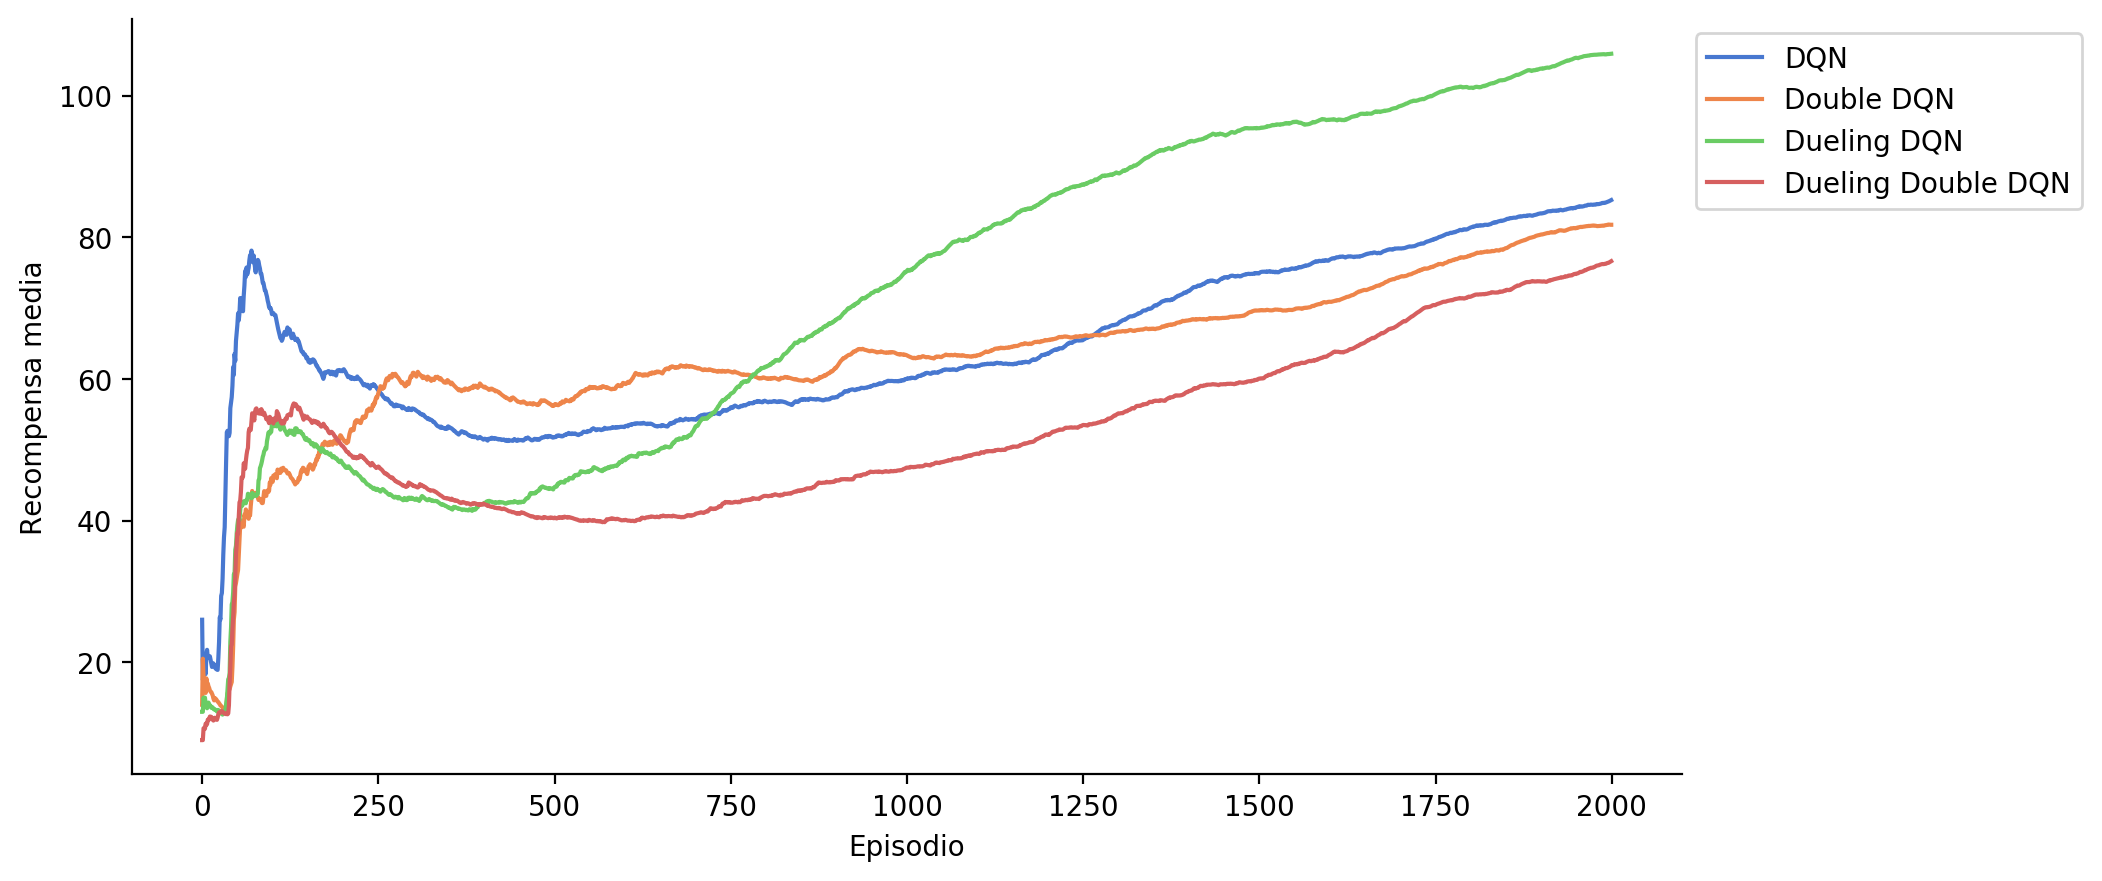

In [41]:
agent = DQN(gym.make('Acrobot-v1'), n_episodes=EPISODES, debug=DEBUG)
scoresDQN, meanDQN = agent.run()

La estrategia Dueling DQN es la que mejor performance tiene. Selecionamos esa estrategia y realizamos una selección de hiperparámetros.

# Selección de hiperparámetros para Dueling DQN

Realizamos un grid search para diferentes configuraciones de las redes, hidden_layers = {1,2,3}, layer_size={6,12,24}, adv_layers={0,1,2}

In [108]:
%run ./Final-Lab.py

[Episode 0] - Mean reward 10.0.
[Episode 19] - Mean reward 13.75.
[Episode 0] - Mean reward 11.0.
[Episode 19] - Mean reward 13.75.
[Episode 0] - Mean reward 22.0.
[Episode 19] - Mean reward 13.55.
[Episode 0] - Mean reward 26.0.


KeyboardInterrupt: 

<Figure size 1152x576 with 0 Axes>

In [109]:
df = pd.read_csv("results.csv")

In [110]:
df["unique_key"] = df.apply(lambda i : "Dueling DQN (hidden_layers:%d, layer_size:%d, adv_layers:%d)"%(i.hidden_layers, i.layer_size, i.adv_layers), axis=1)

In [111]:
hue_order = list(df.unique_key.unique())

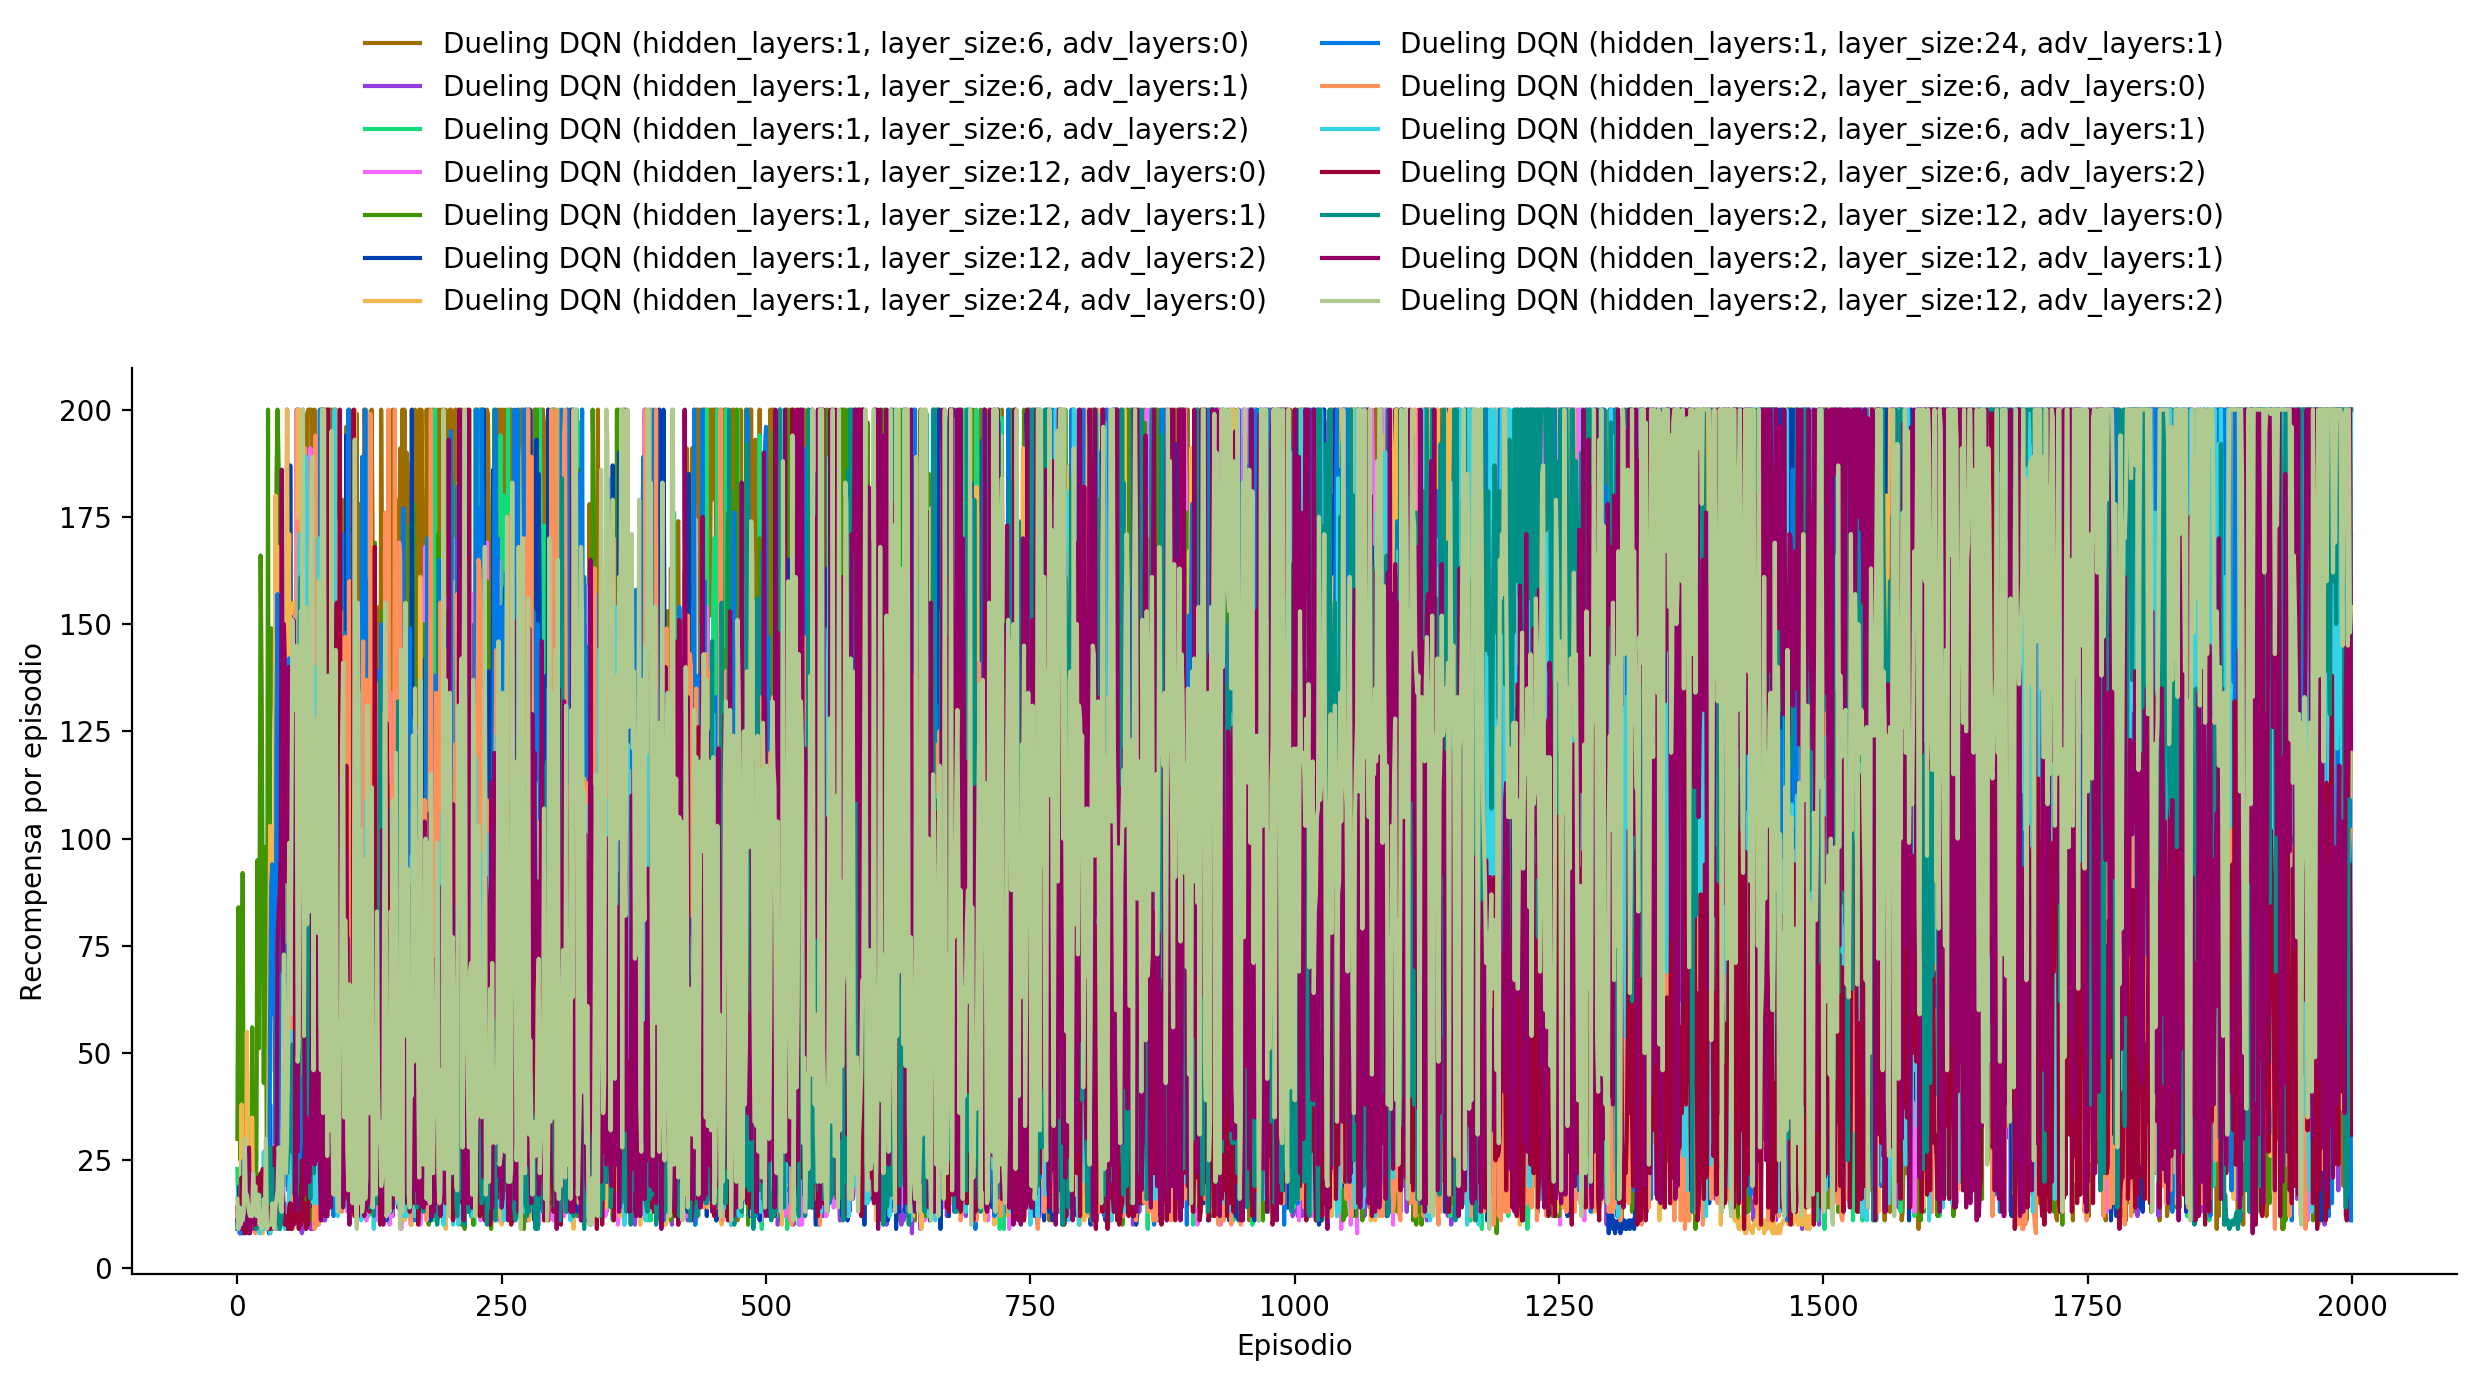

In [112]:

plt.figure(figsize=(15,6),dpi=200)
s=sns.lineplot(data=df, x="Episode", y="score", hue="unique_key", hue_order=hue_order, dashes=False, palette=colors[:len(hue_order)])
sns.despine()
s.set_xlabel("Episodio")
s.set_ylabel("Recompensa por episodio")
plt.legend(hue_order, bbox_to_anchor=(0.5,1.4), ncol=2, title=None, frameon=False, loc=9)

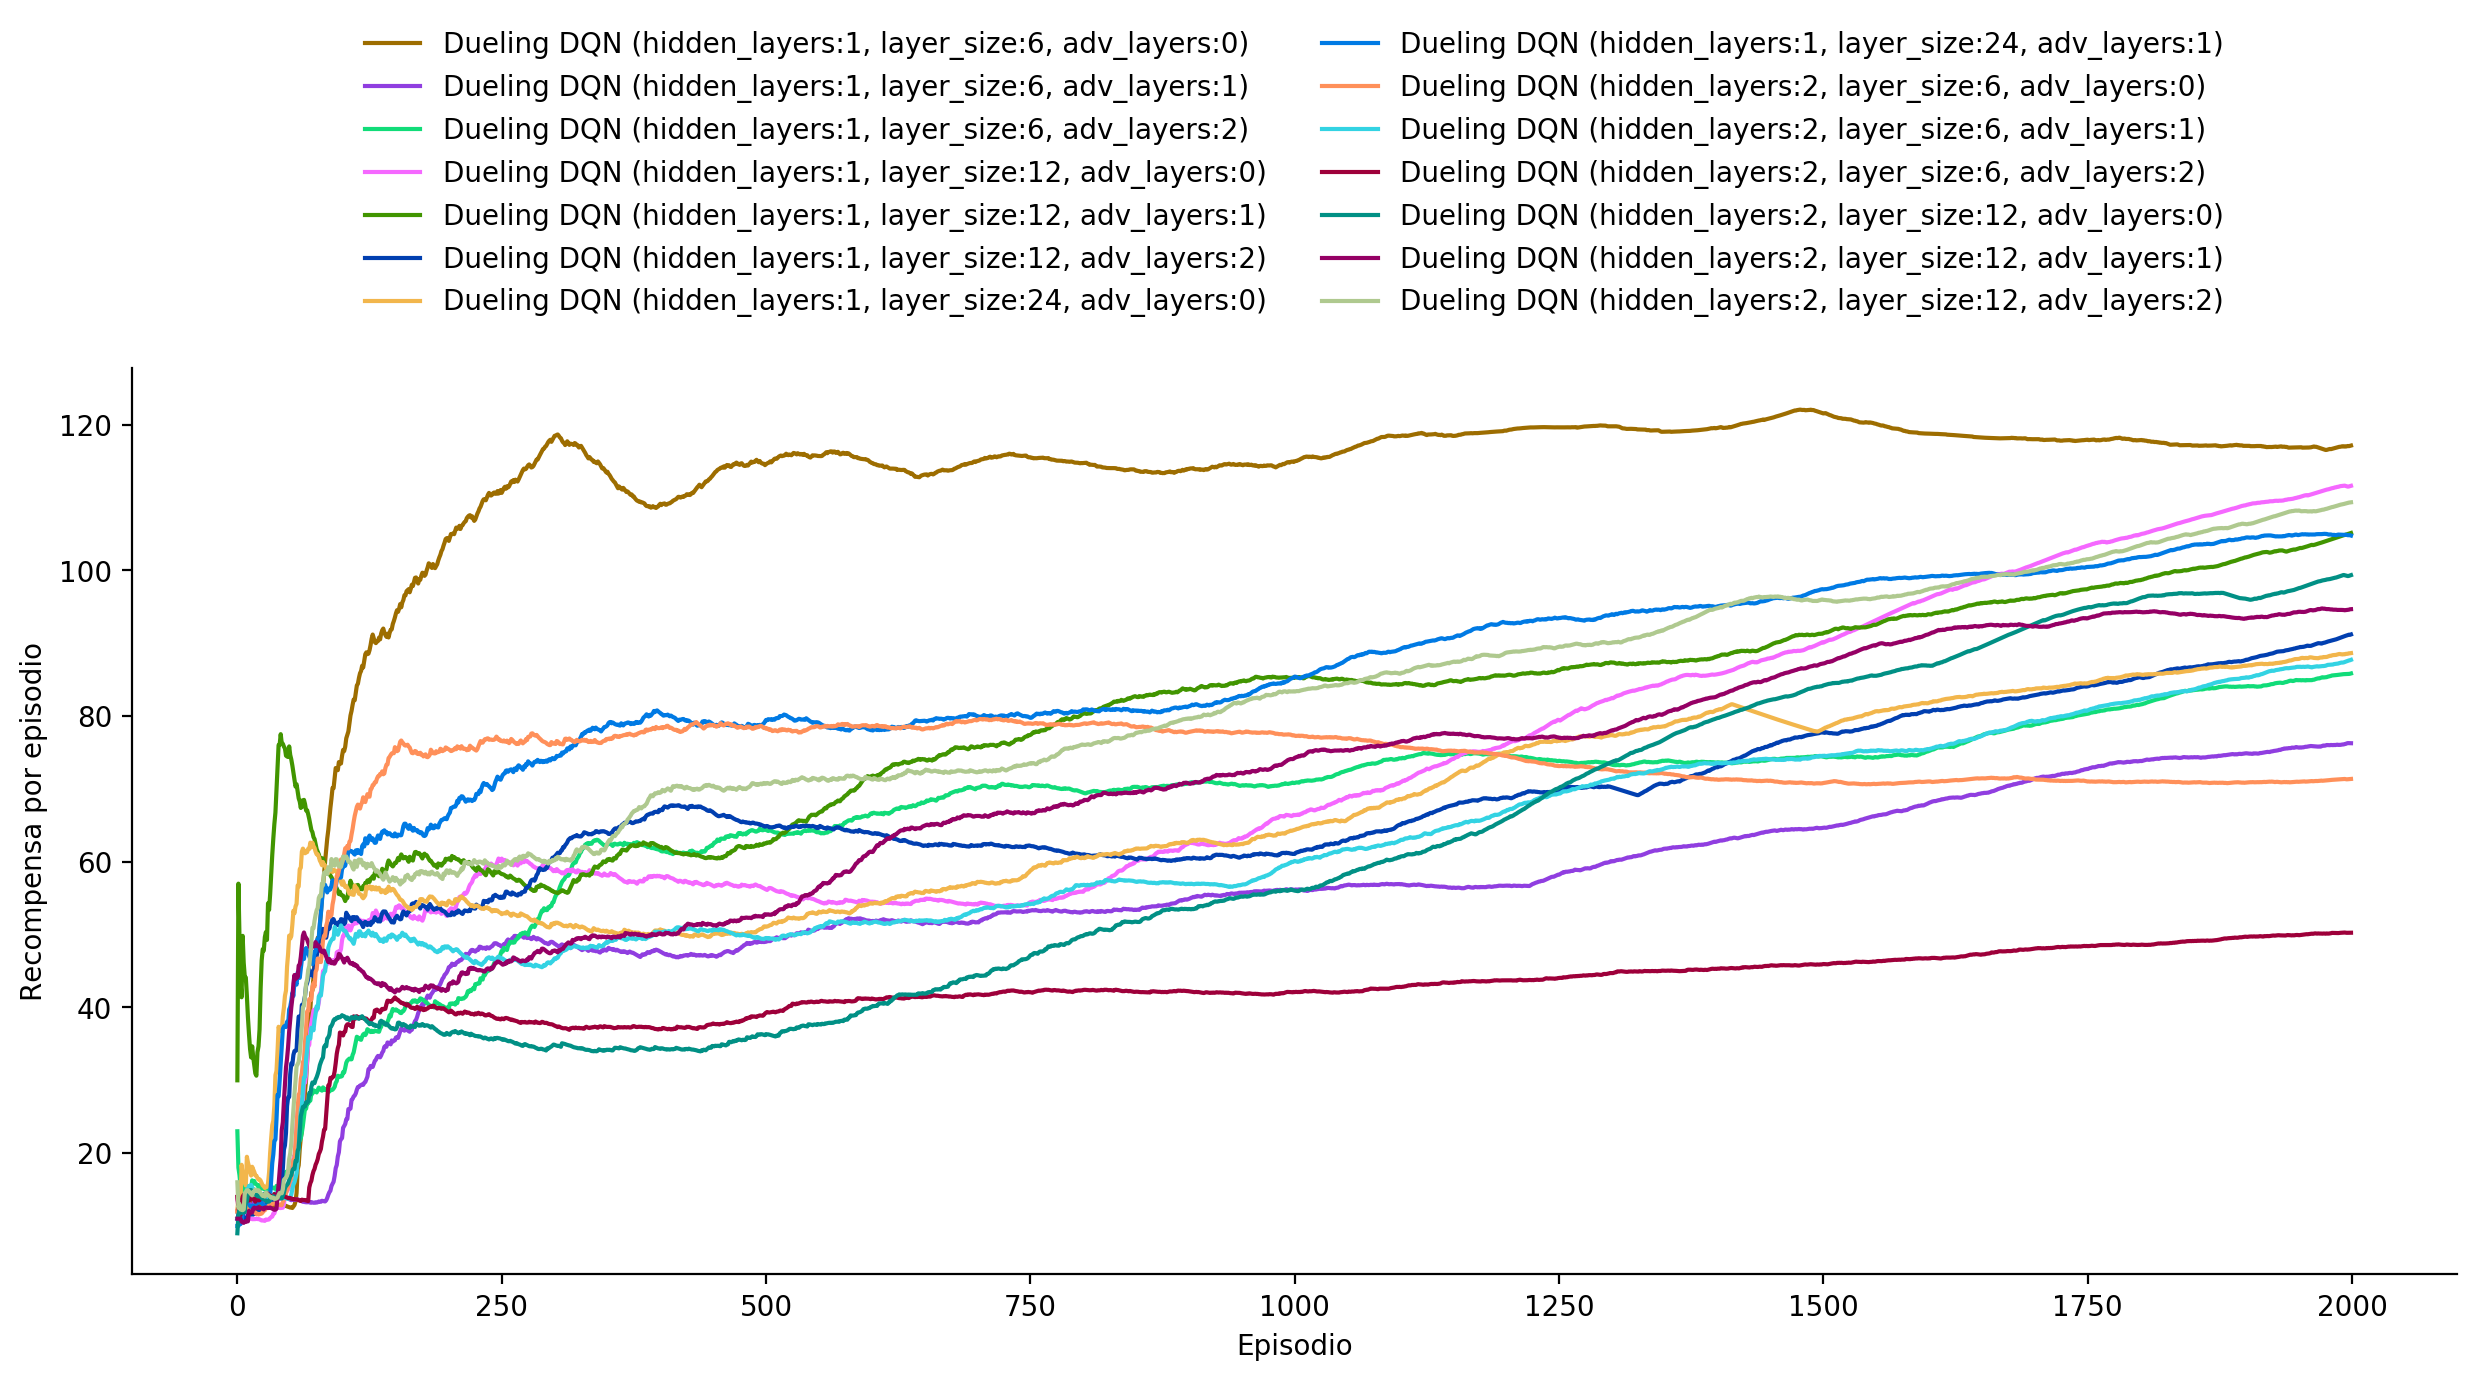

In [113]:

plt.figure(figsize=(15,6),dpi=200)
s=sns.lineplot(data=df, x="Episode", y="mean", hue="unique_key", hue_order=hue_order, dashes=False, palette=colors[:len(hue_order)])
sns.despine()
s.set_xlabel("Episodio")
s.set_ylabel("Recompensa por episodio")
plt.legend(hue_order, bbox_to_anchor=(0.5,1.4), ncol=2, title=None, frameon=False, loc=9)
plt.savefig("mean_DuelingDQN.pdf", format="pdf", bbox_inches="tight")

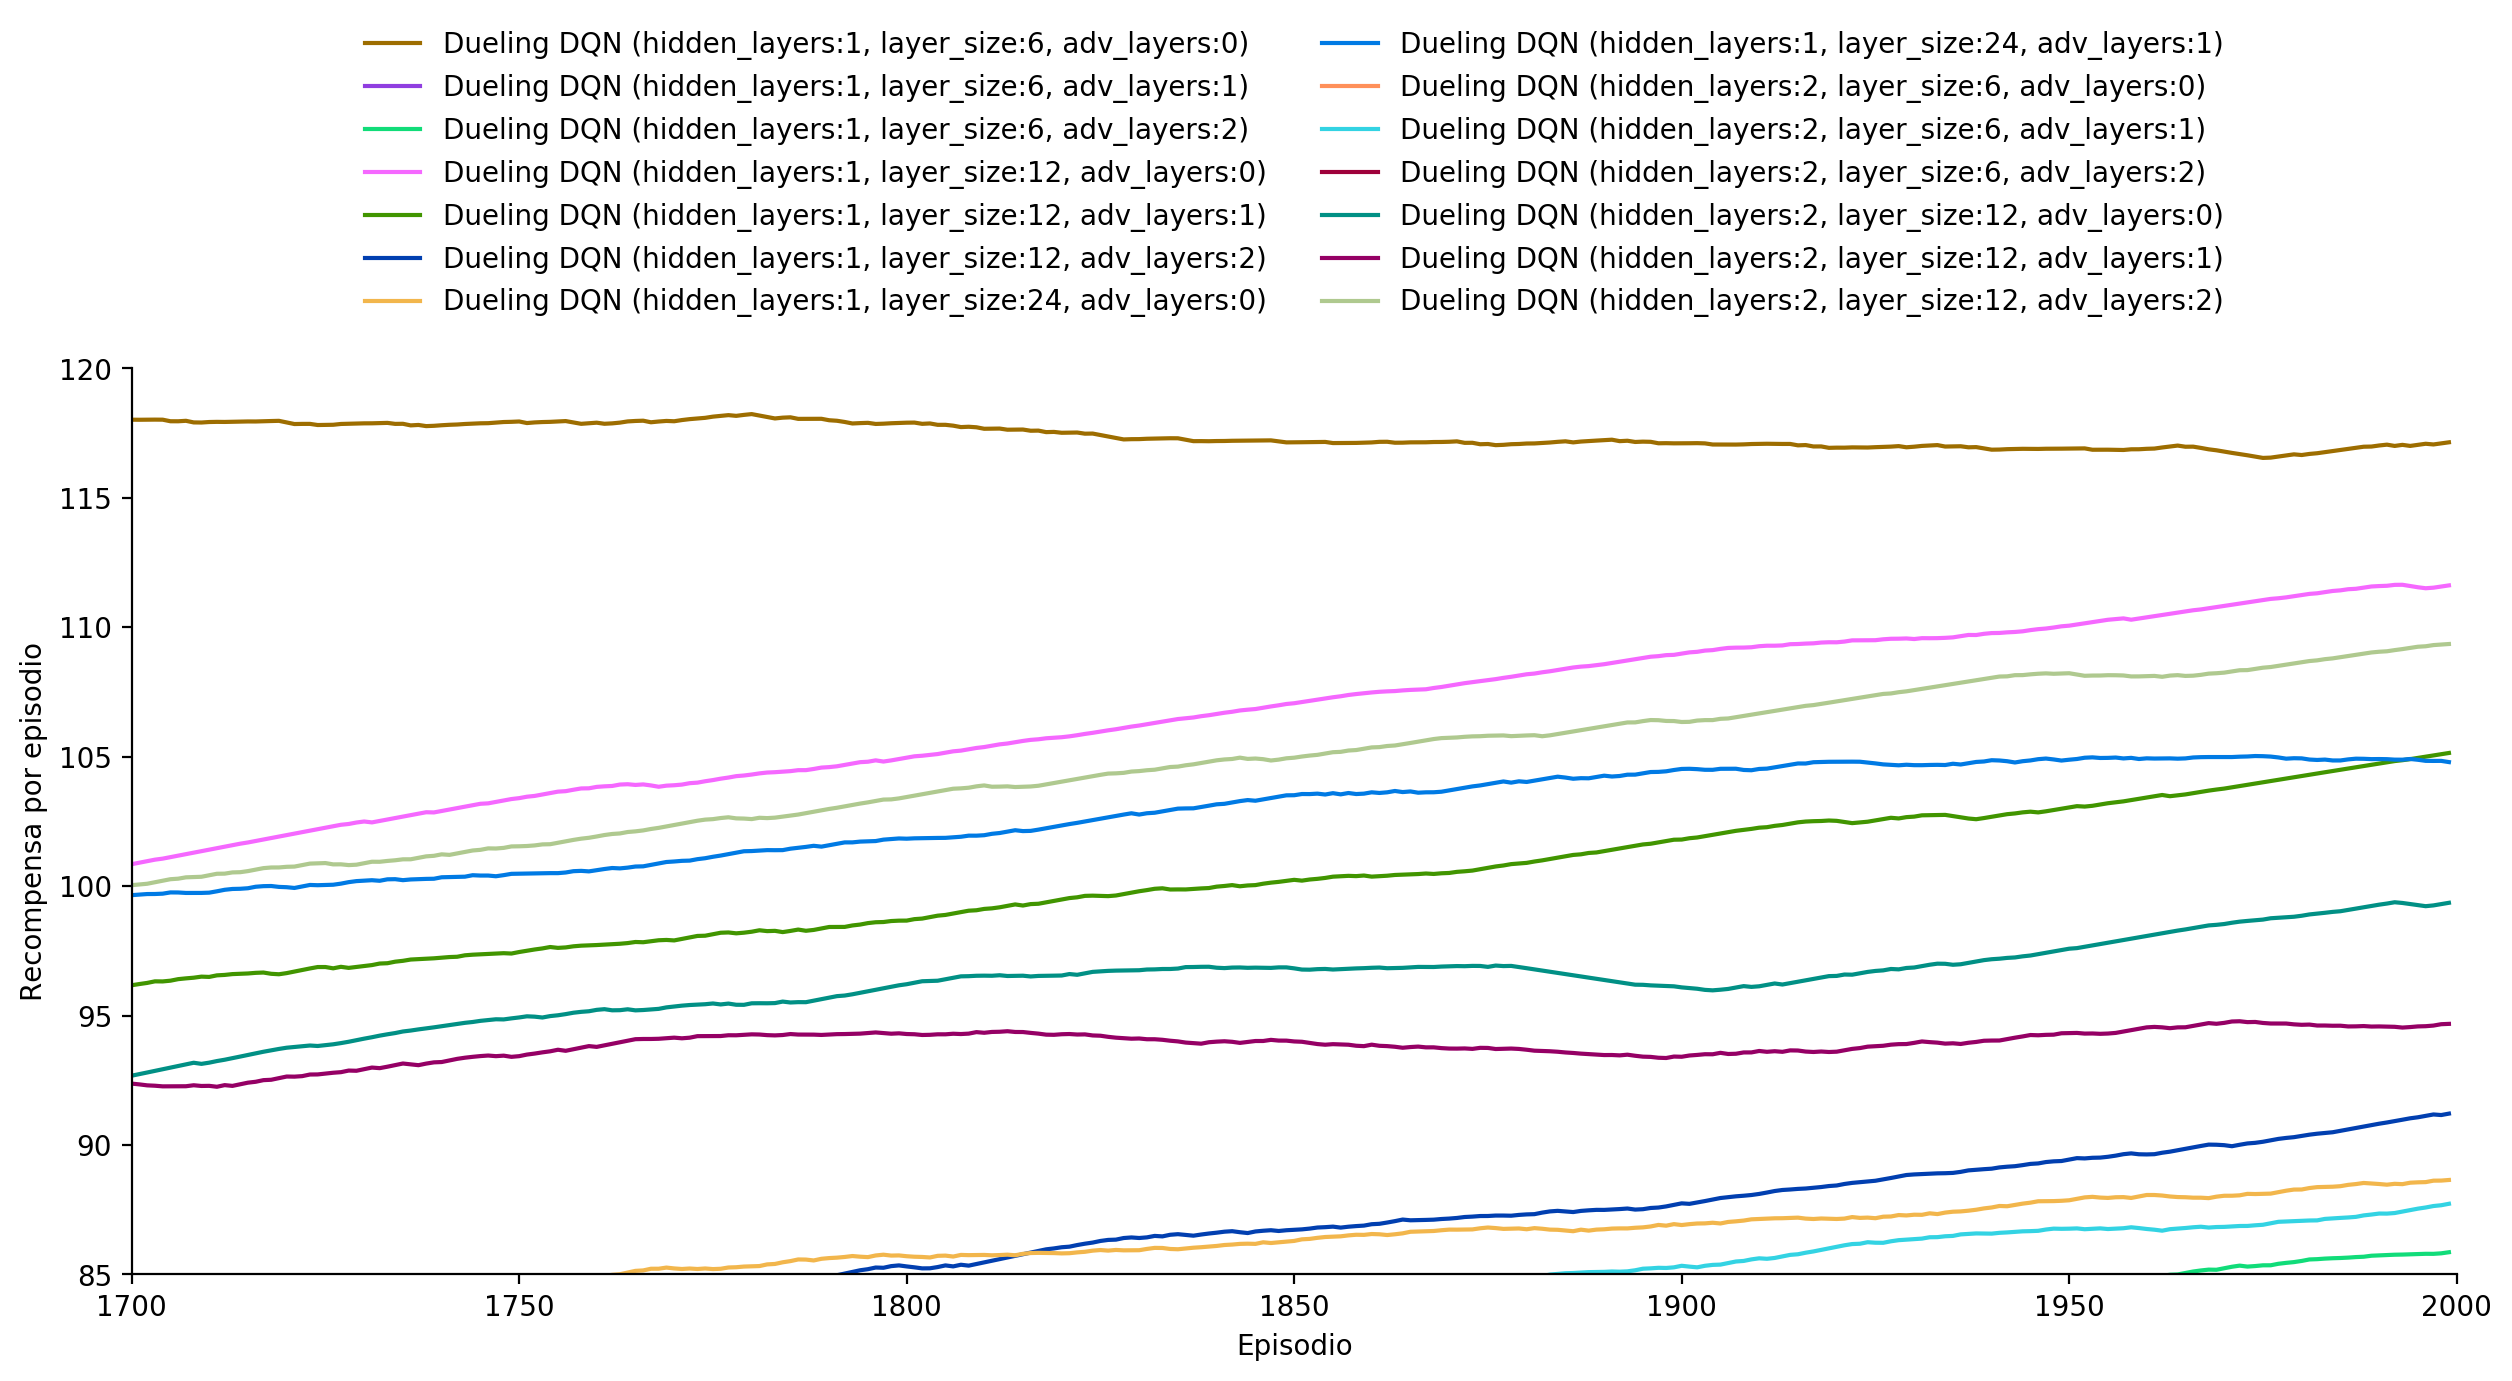

In [114]:

plt.figure(figsize=(15,6),dpi=200)
s=sns.lineplot(data=df, x="Episode", y="mean", hue="unique_key", hue_order=hue_order, dashes=False, palette=colors[:len(hue_order)])
sns.despine()
s.set_xlabel("Episodio")
s.set_ylabel("Recompensa por episodio")
s.set_ylim(85,120)
s.set_xlim(1700,2000)
plt.legend(hue_order, bbox_to_anchor=(0.5,1.4), ncol=2, title=None, frameon=False, loc=9)

# Corremos el mejor modelo para un segundo entorno

In [ ]:
agent = DQN(gym.make('Acrobot-v1'), n_episodes=EPISODES, debug=DEBUG)
scoresDQN, meanDQN = agent.run()